<a href="https://colab.research.google.com/github/MartinPdeS/SuPyMode/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing SuPyMode and depedencies

In [2]:
!python -m pip install SuPyMode --no-cache-dir --quiet
!pip install numpy==2.2.4 --quiet
!pip install scipy==1.15.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.6/675.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.0/457.0 kB 201.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 148.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 159.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 140.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Quick fix: restart the session after the !pip command above.
Go on Runtime/Restart Session

## Importing the package

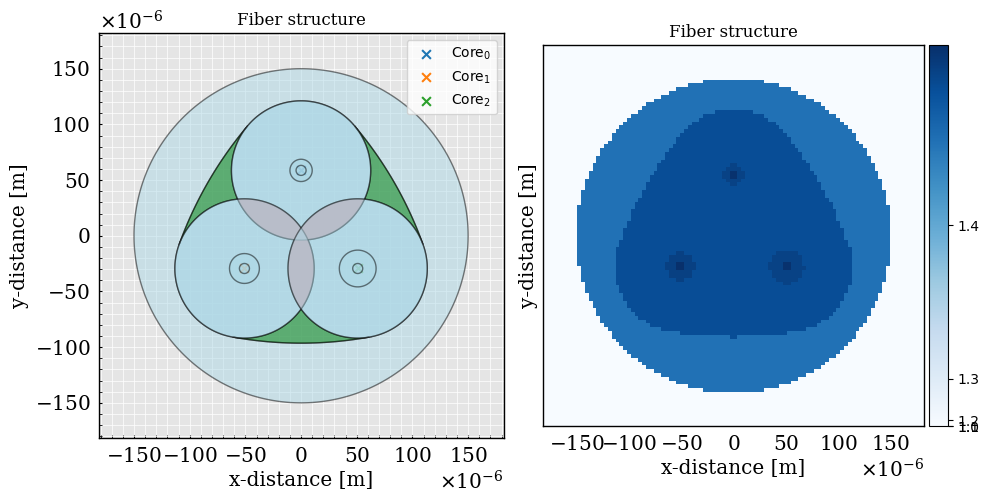

In [ ]:
from SuPyMode.workflow import Workflow, configuration, fiber_catalogue, Boundaries
from google.colab import files

wavelength = 1550e-9

fiber_list = [
    fiber_catalogue.load_fiber('DCF1300S_20', wavelength=wavelength),
    fiber_catalogue.load_fiber('DCF1300S_26', wavelength=wavelength),
    fiber_catalogue.load_fiber('DCF1300S_33', wavelength=wavelength)
]

clad_profile = configuration.ring.FusedProfile_03x03

capillary_tube = fiber_catalogue.CapillaryTube(
    radius=150e-6,
    wavelength=wavelength,
    delta_n=-15e-3
)


workflow = Workflow(
    fiber_list=fiber_list,          # List of fiber to be added in the mesh, the order matters.
    clad_structure=clad_profile,    # Cladding structure, if None provided then no cladding is set.
    capillary_tube=capillary_tube,  # In this case we add a wrapping capillary tube around the fused structure.
    fusion_degree='auto',           # Degree of fusion of the structure if applicable.
    wavelength=wavelength,          # Wavelength used for the mode computation.
    resolution=100,                 # Number of point in the x and y axis [is divided by half if symmetric or anti-symmetric boundaries].
    x_bounds="centering",           # Mesh x-boundary structure.
    y_bounds="centering",           # Mesh y-boundary structure.
    boundaries=[Boundaries()],      # Set of symmetries to be evaluated, each symmetry add a round of simulation
    n_sorted_mode=6,                # Total computed and sorted mode.
    n_added_mode=6,                 # Additional computed mode that are not considered later except for field comparison [the higher the better but the slower].
    plot_geometry=True,             # Plot the geometry mesh before computation.
    debug_mode=1,                   # Define the degree of debug printout, from 0 to 3. [Does not work properly on jupyter notebooks]
    auto_label=True,                # Auto labeling the mode. Label are not always correct and should be verified afterwards.
    itr_final=0.1,                  # Final value of inverse taper ratio to simulate
    index_scrambling=0e-4           # Scrambling of refractive index value in order to lift mode degeneracy [useful for some analysis]
)

superset = workflow.get_superset()

In [ ]:
""" Saving file locally """

filename = workflow._get_auto_generated_filename_()

superset.save_instance(filename, directory='.')

files.download(filename + ".pickle")

## Plotting the supermode fields

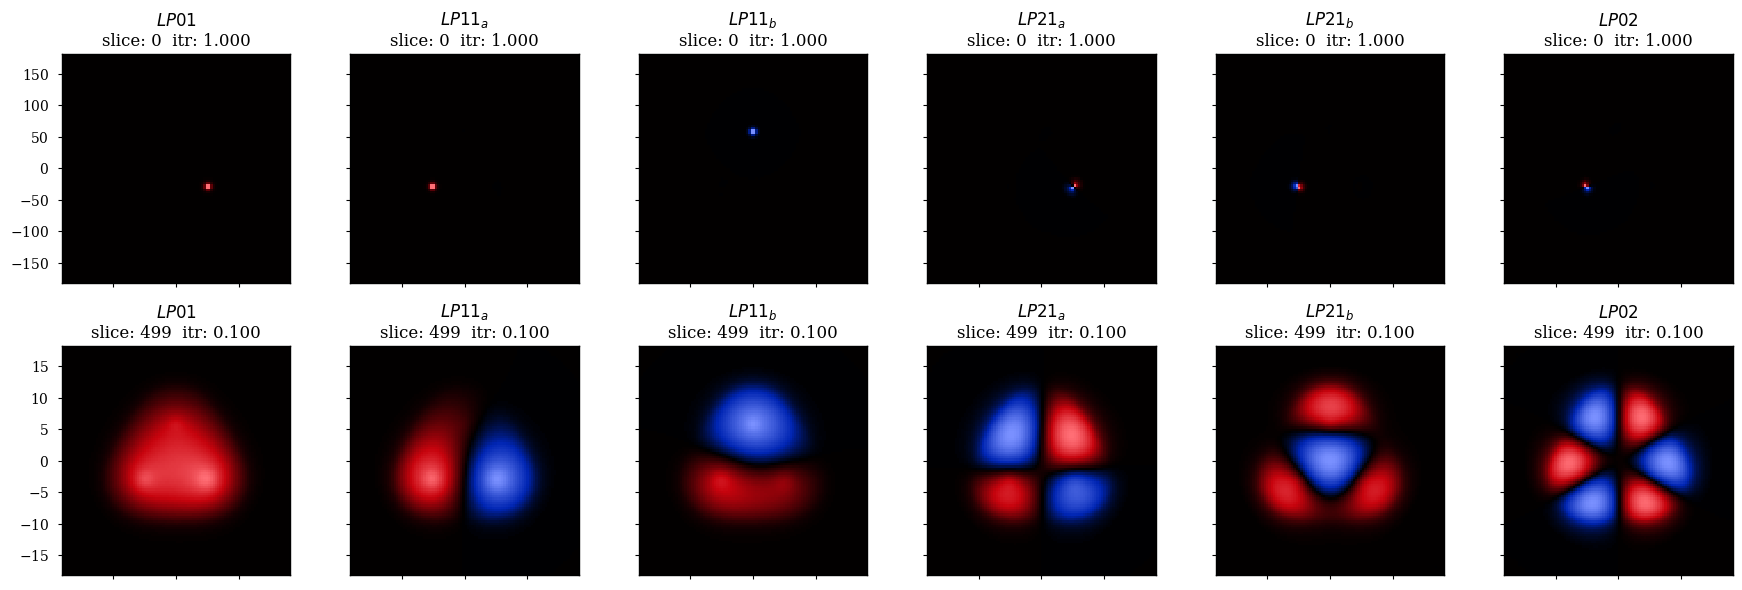

In [ ]:
figure = superset.plot(plot_type='field', itr_list=[1.0, 0.1])

figure.show()

## Ploting the supermode effective index

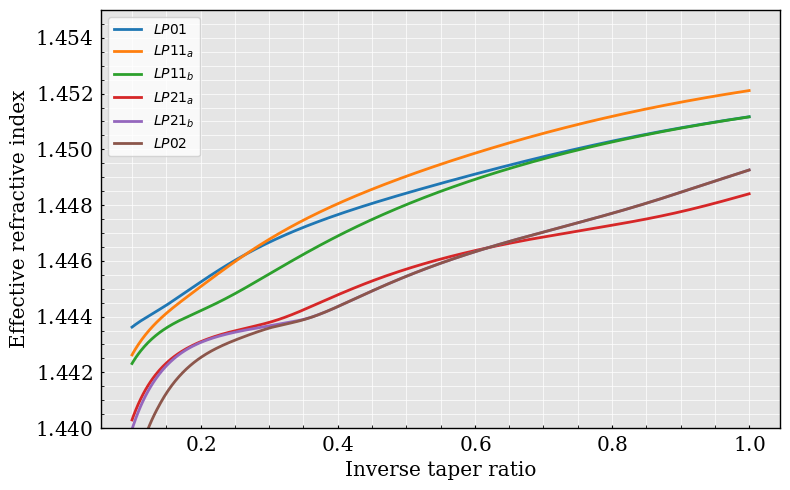

In [ ]:
figure = superset.plot(plot_type='index')
figure.show()

## Plotting the supermode normalized coupling

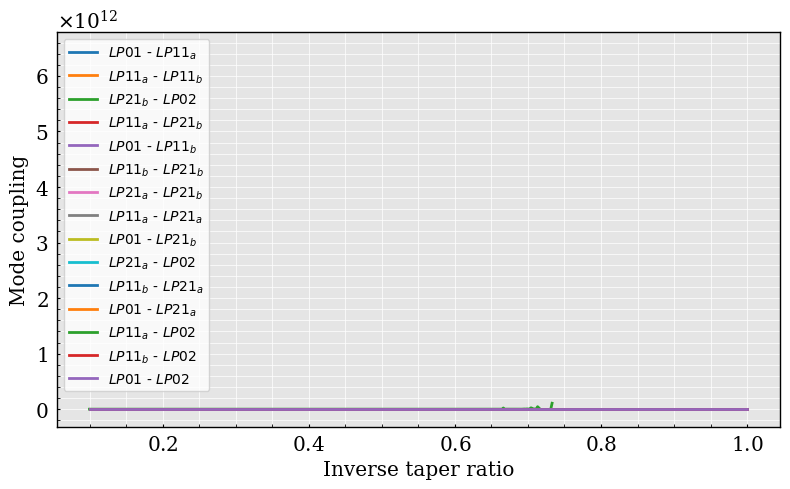

In [ ]:
figure = superset.plot(plot_type='normalized-coupling')
figure.show()

## Plotting the supermode adiabatic criterion

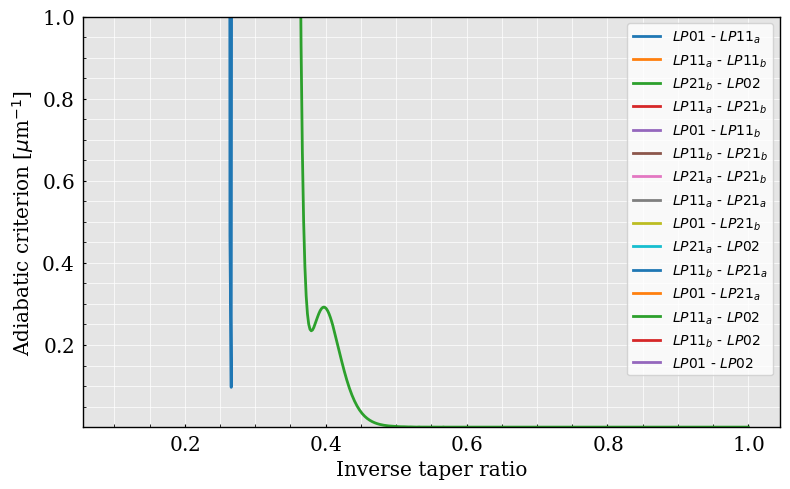

In [ ]:
figure = superset.plot(plot_type='adiabatic')
figure.show()